# Load data

In [1]:
import pandas as pd
import os

def load_data() -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Load and preprocess MovieLens 100k data.
    Returns (ratings_df, users_df, movies_df)

    ratings_df: user_id, movie_id, rating, timestamp
    users_df: user_id, gender, age, occupation, zip
    movies_df: movie_id, title, genres (one-hot genre columns)
    """
    
    ROOT_DIR = os.getcwd()
    ROOT_DIR = os.path.abspath(os.path.join(ROOT_DIR, '..'))
    DATA_DIR = os.path.join(ROOT_DIR, 'ml-100k')

    ratings = pd.read_csv(os.path.join(DATA_DIR, 'ratings.csv'))
    ratings.to_csv(os.path.join(DATA_DIR, 'mod_ratings.csv'), sep='\t', index=False)
    movies = pd.read_csv(os.path.join(DATA_DIR, 'movies.csv'))
    movies.to_csv(os.path.join(DATA_DIR, 'mod_movies.csv'), sep='\t', index=False)

    #Loading datasets
    ratings_list = [i.strip().split("\t") for i in open(os.path.join(DATA_DIR,'mod_ratings.csv'), 'r').readlines()]
    ratings_df = pd.DataFrame(ratings_list[1:], columns = ['user_id', 'movie_id', 'rating', 'timestamp'])
    ratings_df['user_id'] = ratings_df['user_id'].apply(pd.to_numeric)
    ratings_df['movie_id'] = ratings_df['movie_id'].apply(pd.to_numeric)
    ratings_df['rating'] = ratings_df['rating'].astype(float)

    movies_list = [i.strip().split("\t") for i in open(os.path.join(DATA_DIR,'mod_movies.csv'),encoding='latin-1').readlines()]
    movies_df = pd.DataFrame(movies_list[1:], columns = ['movie_id', 'title', 'genres'])
    movies_df['movie_id'] = movies_df['movie_id'].apply(pd.to_numeric)

    # Expand genres into one-hot
    genres_list = sorted({g for sub in movies_df['genres'].str.split('|') for g in sub})
    for genre in genres_list:
        movies_df[genre] = movies_df['genres'].str.contains(genre).astype(int)

    movies_df.drop(columns=['genres'], inplace=True)

    users_1m_path = os.path.join(DATA_DIR, 'users-1m.dat')
    users_1m_list = [i.strip().split("::") for i in open(users_1m_path, 'r').readlines()]
    users_1m_df = pd.DataFrame(users_1m_list, columns=['user_id', 'gender', 'age', 'occupation', 'zip_code'])
    users_1m_df['user_id'] = users_1m_df['user_id'].apply(pd.to_numeric)

    users_100k = users_1m_df[users_1m_df['user_id'].isin(ratings_df['user_id'])]
    users_100k.to_csv(os.path.join(DATA_DIR, 'users.csv'), sep='\t', index=False)

    users_list = [i.strip().split("\t") for i in open(os.path.join(DATA_DIR,'users.csv'), 'r').readlines()]
    users_df = pd.DataFrame(users_list[1:], columns=['user_id', 'gender', 'age', 'occupation', 'zip_code'])

    return ratings_df, users_df, movies_df

In [8]:
ratings_df, users_df, movies_df = load_data()
ratings_df.head()

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_44942/1118964766.py:37: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  movies_df[genre] = movies_df['genres'].str.contains(genre).astype(int)


,user_id,movie_id,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [9]:
users_df.head()

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [87]:
movies_df.head()

,movie_id,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# Create a RL env

In [141]:
import gym
from gym import spaces
import numpy as np
import random

class MovieLensSimpleEnv(gym.Env):
    """
    A clean and stable MovieLens environment for Keras-RL.
    - States: History of watched movie IDs (normalized once).
    - Actions: Recommend a movie (by action index).
    - Reward: +1 if user liked it (rating >= 4), else 0.
    """

    def __init__(self, ratings_df, movies_df, users_df, state_size=10, max_steps=10):
        super(MovieLensSimpleEnv, self).__init__()

        self.ratings_df = ratings_df
        self.movies_df = movies_df
        self.users_df = users_df
        self.state_size = state_size
        self.max_steps = max_steps
        
        self.user_ids = ratings_df['user_id'].unique()
        self.movie_ids = movies_df['movie_id'].unique()
        self.num_movies = len(self.movie_ids)

        self.movie_id_to_idx = {mid: idx for idx, mid in enumerate(self.movie_ids)}
        self.idx_to_movie_id = {idx: mid for idx, mid in enumerate(self.movie_ids)}
        
        self.action_space = spaces.Discrete(self.num_movies)
        self.observation_space = spaces.Box(
            low=0.0, high=1.0, shape=(self.state_size,), dtype=np.float32
        )
        
        self.reset()

    def reset(self):
        self.current_user = random.choice(self.user_ids)
        self.user_history = self.ratings_df[self.ratings_df['user_id'] == self.current_user]
        self.liked_movies = set(
            self.user_history[self.user_history['rating'] >= 4.0]['movie_id'].values
        )
        self.all_movies = set(self.user_history['movie_id'].values)

        sampled_movies = np.random.choice(list(self.all_movies), size=self.state_size, replace=True)
        self.state = np.array(
            [self.movie_id_to_idx[mid] / self.num_movies for mid in sampled_movies],
            dtype=np.float32
        )
        self.steps = 0

        return self.state

    def step(self, action):
        movie_id = self.idx_to_movie_id[action]
        
        reward = 1 if movie_id in self.liked_movies else 0

        # Move state window
        new_state_value = action / self.num_movies
        self.state = np.roll(self.state, -1)
        self.state[-1] = new_state_value
        
        self.steps += 1
        done = self.steps >= self.max_steps

        # info = {'true items': [int(m) for m in self.liked_movies]}  # No problematic info dictionary
        info = {}

        return self.state, reward, done, info

    def render(self, mode='human'):
        print(f"User {self.current_user}, State: {self.state}")

    def close(self):
        pass


In [142]:
# Create environment
env = MovieLensSimpleEnv(ratings_df, movies_df, users_df)

nb_actions = env.action_space.n
print('# actions: ', nb_actions)

env.step(env.action_space.sample())

# actions:  9742


(array([0.08499281, 0.15623075, 0.9135701 , 0.6784028 , 0.19903511,
        0.9564771 , 0.19903511, 0.06312872, 0.06292342, 0.9097721 ],
       dtype=float32),
 0,
 False,
 {})

# Build DQN agent

In [143]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense
from keras.optimizers import Adam

def build_dqn_model(state_size, num_movies, nb_actions):
    """
    Build a stable DQN model for movie recommendation.
    """
    embedding_dim = 32

    movie_input = Input(shape=(1, state_size), dtype='float32')  # <- Notice (1, state_size)

    # Flatten first to remove window_length dimension
    flat_input = Flatten()(movie_input)

    discrete_movie_indices = flat_input * num_movies
    discrete_movie_indices = tf.cast(discrete_movie_indices, tf.int32)

    embeddings = Embedding(input_dim=num_movies, output_dim=embedding_dim)(discrete_movie_indices)
    x = Flatten()(embeddings)
    
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(nb_actions, activation='linear')(x)

    model = Model(inputs=movie_input, outputs=output)

    return model


In [144]:
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory

# Build model
model = build_dqn_model(
    state_size=env.state_size,
    num_movies=len(env.movie_ids),
    nb_actions=len(env.movie_ids)
)

# Configure agent
memory = SequentialMemory(limit=50000, window_length=1)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(),
                              attr='eps',
                              value_max=1.0,
                              value_min=0.1,
                              value_test=0.05,
                              nb_steps=20000)

dqn = DQNAgent(
    model=model,
    nb_actions=len(env.movie_ids),
    memory=memory,
    nb_steps_warmup=500,
    target_model_update=1e-2,
    policy=policy,
    enable_double_dqn=True
)

# Compile agent
dqn.compile(optimizer=Adam(learning_rate=1e-4), metrics=['mae'])


2025-04-27 18:37:58.432927: W tensorflow/c/c_api.cc:291] Operation '{name:'embedding_14/embeddings/Assign' id:13613 op device:{requested: '', assigned: ''} def:{{{node embedding_14/embeddings/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](embedding_14/embeddings, embedding_14/embeddings/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


# Train

In [151]:
dqn.fit(env, nb_steps=10000, visualize=False, verbose=2)

Training for 10000 steps ...
   10/10000: episode: 1, duration: 0.027s, episode steps:  10, steps per second: 364, episode reward:  0.000, mean reward:  0.000 [ 0.000,  0.000], mean action: 4574.000 [1030.000, 8837.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   20/10000: episode: 2, duration: 0.022s, episode steps:  10, steps per second: 457, episode reward:  0.000, mean reward:  0.000 [ 0.000,  0.000], mean action: 3416.100 [610.000, 7431.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   30/10000: episode: 3, duration: 0.020s, episode steps:  10, steps per second: 507, episode reward:  0.000, mean reward:  0.000 [ 0.000,  0.000], mean action: 4153.200 [1155.000, 7621.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   40/10000: episode: 4, duration: 0.019s, episode steps:  10, steps per second: 523, episode reward:  0.000, mean reward:  0.000 [ 0.000,  0.000], mean action: 4812.200 [801.000, 8044.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   50/10000: episode: 5, 

In [ ]:
dqn.save_weights('dqn_weights.h5f', overwrite=True)

# Evaluation

In [152]:
import numpy as np

def evaluate_dqn(dqn, env, top_k=10, num_users=100):
    precision_list = []
    recall_list = []
    ndcg_list = []
    map_list = []

    env.reset()

    for _ in range(num_users):
        obs = env.reset()
        done = False
        total_recommended = []
        total_liked = list(env.liked_movies)

        recommended_set = set()

        while not done:
            # Get Q-values
            q_values = dqn.compute_q_values(np.expand_dims(obs, axis=0))
            q_values = q_values[0]  # shape (num_actions,)

            # Pick top_k movies (avoid recommending same movie twice)
            ranked_movie_indices = np.argsort(q_values)[::-1]
            recommended = []
            for idx in ranked_movie_indices:
                movie_id = env.movie_ids[idx]
                if movie_id not in recommended_set:
                    recommended.append(movie_id)
                    recommended_set.add(movie_id)
                if len(recommended) == top_k:
                    break

            total_recommended.extend(recommended)

            # We only need one step to evaluate, no full rollout
            done = True

        # --- Metrics ---
        # True positives
        hits = [1 if r in total_liked else 0 for r in total_recommended]

        # Precision@k
        precision = np.sum(hits) / top_k
        precision_list.append(precision)

        # Recall@k
        recall = np.sum(hits) / max(len(total_liked), 1)
        recall_list.append(recall)

        # NDCG@k
        dcg = np.sum([
            hit / np.log2(idx + 2) for idx, hit in enumerate(hits)
        ])
        ideal_hits = sorted([1] * min(len(total_liked), top_k) + [0] * (top_k - min(len(total_liked), top_k)), reverse=True)
        idcg = np.sum([
            hit / np.log2(idx + 2) for idx, hit in enumerate(ideal_hits)
        ])
        ndcg = dcg / idcg if idcg > 0 else 0.0
        ndcg_list.append(ndcg)

        # MAP@k
        num_hits = 0
        ap_sum = 0.0
        for idx, hit in enumerate(hits):
            if hit == 1:
                num_hits += 1
                ap_sum += num_hits / (idx + 1)
        map_at_k = ap_sum / max(np.sum(hits), 1)
        map_list.append(map_at_k)

    # Aggregate results safely
    precision_final = np.nanmean(precision_list)
    recall_final = np.nanmean(recall_list)
    ndcg_final = np.nanmean(ndcg_list)
    map_final = np.nanmean(map_list)

    print(f"Precision@{top_k}: {precision_final:.4f}")
    print(f"Recall@{top_k}: {recall_final:.4f}")
    print(f"NDCG@{top_k}: {ndcg_final:.4f}")
    print(f"MAP@{top_k}: {map_final:.4f}")

    return precision_final, recall_final, ndcg_final, map_final


In [ ]:
dqn.load_weights('dqn_weights.h5f')
precision, recall, ndcg, map_k = evaluate_dqn(dqn, env, top_k=10, num_users=100)

print(f"Final DQN Performance:")
print(f" Precision@10 : {precision*100:.2f}%")
print(f" Recall@10    : {recall*100:.2f}%")
print(f" NDCG@10      : {ndcg*100:.2f}%")
print(f" MAP@10       : {map_k*100:.2f}%")


Precision@10: 0.0290
Recall@10: 0.0045
NDCG@10: 0.0638
MAP@10: 0.2900
Final DQN Performance:
 Precision@10 : 2.90%
 Recall@10    : 0.45%
 NDCG@10      : 6.38%
 MAP@10       : 29.00%


# Improvement

## Build Stronger DQN agent

In [200]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten

def build_stronger_dqn(state_size, nb_actions):
    inputs = Input(shape=(1, state_size))  # Keras-RL expects window_length=1
    x = Flatten()(inputs)

    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(nb_actions, activation='linear')(x)

    model = Model(inputs=inputs, outputs=output)
    return model


In [165]:
# Build model
model2 = build_stronger_dqn(
    state_size=env.state_size,
    nb_actions=len(env.movie_ids)
)

# Configure agent
memory2 = SequentialMemory(limit=50000, window_length=1)
policy2 = LinearAnnealedPolicy(EpsGreedyQPolicy(),
                              attr='eps',
                              value_max=1.0,
                              value_min=0.05,
                              value_test=0.01,
                              nb_steps=50000)

dqn2 = DQNAgent(
    model=model2,
    nb_actions=len(env.movie_ids),
    memory=memory2,
    nb_steps_warmup=500,
    target_model_update=1e-2,
    policy=policy2,
    enable_double_dqn=True
)

optimizer2 = Adam(learning_rate=5e-4, clipnorm=1.0)
dqn2.compile(optimizer=optimizer2, metrics=['mae'])


2025-04-27 19:02:39.219635: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_90_1/bias/Assign' id:15615 op device:{requested: '', assigned: ''} def:{{{node dense_90_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_90_1/bias, dense_90_1/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [166]:
dqn2.fit(env, nb_steps=5000, visualize=False, verbose=2)

Training for 5000 steps ...


/opt/anaconda3/envs/ddpg/lib/python3.9/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-04-27 19:02:42.382834: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_91/BiasAdd' id:15546 op device:{requested: '', assigned: ''} def:{{{node dense_91/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_91/MatMul, dense_91/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-04-27 19:02:42.876378: W tensorflow/c/c_api.cc:291] Operation '{name:'count_93/Assign' id:15814 op device:{requested: '', assigned: ''} def:{{{node count_93/Assign}} = AssignVariableOp[_has_manual_

   10/5000: episode: 1, duration: 1.129s, episode steps:  10, steps per second:   9, episode reward:  0.000, mean reward:  0.000 [ 0.000,  0.000], mean action: 5668.600 [1656.000, 8960.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   20/5000: episode: 2, duration: 0.015s, episode steps:  10, steps per second: 653, episode reward:  0.000, mean reward:  0.000 [ 0.000,  0.000], mean action: 6819.200 [1858.000, 9004.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   30/5000: episode: 3, duration: 0.016s, episode steps:  10, steps per second: 642, episode reward:  0.000, mean reward:  0.000 [ 0.000,  0.000], mean action: 5125.300 [864.000, 8621.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   40/5000: episode: 4, duration: 0.015s, episode steps:  10, steps per second: 657, episode reward:  0.000, mean reward:  0.000 [ 0.000,  0.000], mean action: 4339.500 [1068.000, 8311.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   50/5000: episode: 5, duration: 0.015s, episode steps: 

/opt/anaconda3/envs/ddpg/lib/python3.9/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-04-27 19:02:44.339536: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_91_1/BiasAdd' id:15646 op device:{requested: '', assigned: ''} def:{{{node dense_91_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_91_1/MatMul, dense_91_1/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-04-27 19:02:45.057869: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_103/AddN' id:15930 op device:{requested: '', assigned: ''} def:{{{node loss_103/AddN}} = AddN[N=2, T=DT_FLOAT, _ha

  510/5000: episode: 51, duration: 4.294s, episode steps:  10, steps per second:   2, episode reward:  0.000, mean reward:  0.000 [ 0.000,  0.000], mean action: 4659.000 [1101.000, 9730.000],  loss: 0.004177, mae: 0.007409, mean_q: 0.033689, mean_eps: 0.990405
  520/5000: episode: 52, duration: 0.292s, episode steps:  10, steps per second:  34, episode reward:  0.000, mean reward:  0.000 [ 0.000,  0.000], mean action: 6735.300 [4437.000, 9078.000],  loss: 0.008017, mae: 0.007550, mean_q: 0.040306, mean_eps: 0.990224
  530/5000: episode: 53, duration: 0.319s, episode steps:  10, steps per second:  31, episode reward:  1.000, mean reward:  0.100 [ 0.000,  1.000], mean action: 3105.600 [70.000, 6250.000],  loss: 0.004571, mae: 0.008335, mean_q: 0.053590, mean_eps: 0.990034
  540/5000: episode: 54, duration: 0.273s, episode steps:  10, steps per second:  37, episode reward:  0.000, mean reward:  0.000 [ 0.000,  0.000], mean action: 5124.100 [623.000, 9077.000],  loss: 0.000080, mae: 0.0088

In [167]:
precision, recall, ndcg, map_k = evaluate_dqn(dqn2, env, top_k=10, num_users=100)

Precision@10: 0.0300
Recall@10: 0.0054
NDCG@10: 0.0660
MAP@10: 0.3000


# Visualization

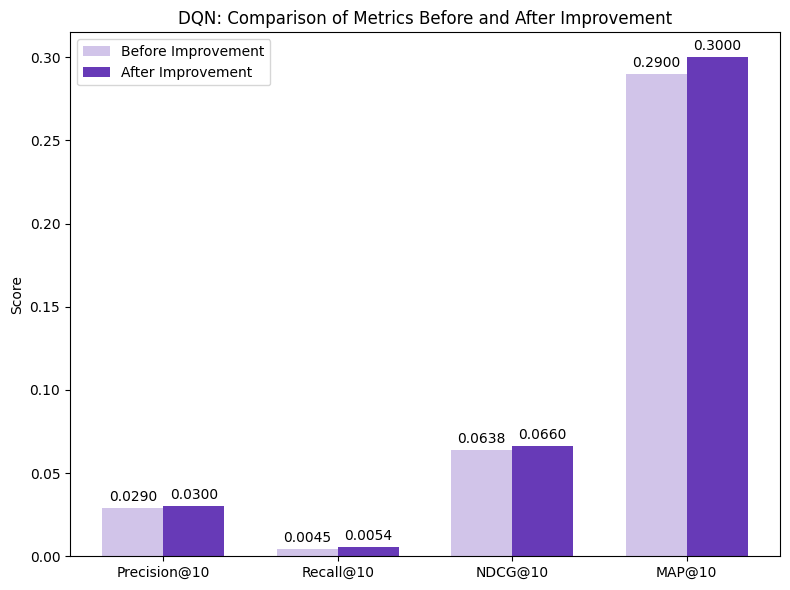

In [201]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
metrics = ['Precision@10', 'Recall@10', 'NDCG@10', 'MAP@10']

# Values
before = [0.0290, 0.0045, 0.0638, 0.2900]
after = [0.0300, 0.0054, 0.0660, 0.3000]

x = np.arange(len(metrics))  # label locations
width = 0.35  # bar width

# Create subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Plot bars
rects1 = ax.bar(x - width/2, before, width, label='Before Improvement', color='#d1c4e9')
rects2 = ax.bar(x + width/2, after, width, label='After Improvement', color='#673ab7')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Score')
ax.set_title('DQN: Comparison of Metrics Before and After Improvement')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add bar labels
ax.bar_label(rects1, padding=3, fmt='%.4f')
ax.bar_label(rects2, padding=3, fmt='%.4f')

# Show plot
plt.tight_layout()
plt.show()